In [1]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
from sklearn.preprocessing import MinMaxScaler

# DNN Model for events with negative weights

Next-to-leading order (NLO) event generators produce events with negative weights. However, these events are not physically meaningful. They are only meaningful when integrated over a finite phase space volume, which will yield net positive results. From this view, we can see that in principle, all the events in the NLO should have positive event weights. Any event with negative weight will have event(s) with positive weights near by such that the local probability density is non-negative.

We build a DNN model that will predict positive weights for any given event. The problem is treated as that of a regression model. The positivity is enforced by having a sigmoid layer as the activation function of the output layer. 

In [2]:
netarch = [128, 128]

seqmodel = keras.Sequential()
seqmodel.add(keras.Input(shape=(2,)))
for anet in netarch:
    seqmodel.add(layers.Dense(anet, activation=None))
    seqmodel.add(layers.LeakyReLU())
    seqmodel.add(layers.Dropout(rate=0.01))
seqmodel.add(layers.Dense(1, activation='softplus'))
seqmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               384       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

## W + jets aMC@NLO Delphes

In [3]:
up = uproot.open("wjetsselected.root")
roottree = up['mytree']
df = roottree.pandas.df()
df.columns

Index(['wjet.met', 'wjet.metphi', 'wjet.leppt', 'wjet.lepeta', 'wjet.lepphi',
       'wjet.jetpt', 'wjet.jeteta', 'wjet.etphi', 'wjet.mt', 'wjet.evweight'],
      dtype='object')

In [4]:
# scale inputs to be within the range(0, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
transformed = scaler.fit_transform(df.iloc[:,:-1])

transformeddf = pd.DataFrame(transformed, columns=df.columns[:-1])
transformeddf

,wjet.met,wjet.metphi,wjet.leppt,wjet.lepeta,wjet.lepphi,wjet.jetpt,wjet.jeteta,wjet.etphi,wjet.mt
0,-0.799603,-0.373114,-0.909054,-0.088143,-0.980890,-0.939607,-0.093551,0.431345,-0.927758
1,-0.828742,-0.606478,-0.824440,-0.446612,0.191422,-0.947351,0.266563,-0.645927,-0.792025
2,-0.942136,0.867365,-0.977394,0.135450,0.507349,-0.997193,0.519391,-0.329962,-0.934997
3,-0.823834,-0.090392,-0.956225,-0.912577,-0.513938,-0.951817,-0.030843,0.767760,-0.897048
4,-0.830582,-0.625658,-0.933273,-0.966449,0.477077,-0.987483,0.384980,0.658439,-0.737202
...,...,...,...,...,...,...,...,...,...
4759,-0.927992,0.959401,-0.739537,0.810013,0.287295,-0.906140,0.348302,-0.617482,-0.826558
4760,-0.776422,0.698425,-0.930375,-0.657188,-0.099189,-0.923240,-0.052413,-0.443947,-0.925427
4761,-0.861368,0.393622,-0.965542,0.072334,0.999654,-0.951054,-0.742939,-0.481872,-0.756285
4762,-0.938887,-0.886968,-0.824599,-0.719250,0.510224,-0.969637,0.036026,-0.403381,-0.847299


In [5]:
# prepare inputs and targets

xin = transformeddf[['wjet.met', 'wjet.jetpt']]
weights = df['wjet.evweight']
scaling = max( weights.max(), -weights.min() )
targetweights = weights/scaling

## Training

In [6]:
earlystopping_callback = keras.callbacks.EarlyStopping(patience=5, min_delta=1e-4)
opt = keras.optimizers.Adam(learning_rate=1e-3)

seqmodel.compile(optimizer=opt, loss='MSE')

In [14]:
seqmodel.fit(xin, targetweights, batch_size=64, epochs=20, validation_split=0.5, callbacks=[])

Epoch 1/20
38/38 [==============================] - 0s 6ms/step - loss: 0.6630 - val_loss: 0.6350
Epoch 2/20
38/38 [==============================] - 0s 4ms/step - loss: 0.6623 - val_loss: 0.6343
Epoch 3/20
38/38 [==============================] - 0s 7ms/step - loss: 0.6623 - val_loss: 0.6346
Epoch 4/20
38/38 [==============================] - 0s 4ms/step - loss: 0.6627 - val_loss: 0.6342
Epoch 5/20
38/38 [==============================] - 0s 4ms/step - loss: 0.6618 - val_loss: 0.6343
Epoch 6/20
38/38 [==============================] - 0s 4ms/step - loss: 0.6620 - val_loss: 0.6346
Epoch 7/20
38/38 [==============================] - 0s 4ms/step - loss: 0.6616 - val_loss: 0.6342
Epoch 8/20
38/38 [==============================] - 0s 4ms/step - loss: 0.6629 - val_loss: 0.6364
Epoch 9/20
38/38 [==============================] - 0s 4ms/step - loss: 0.6638 - val_loss: 0.6342
Epoch 10/20
38/38 [==============================] - 0s 4ms/step - loss: 0.6626 - val_loss: 0.6346
Epoch 11/20
38/38 [

In [15]:
yout = seqmodel.predict(xin)

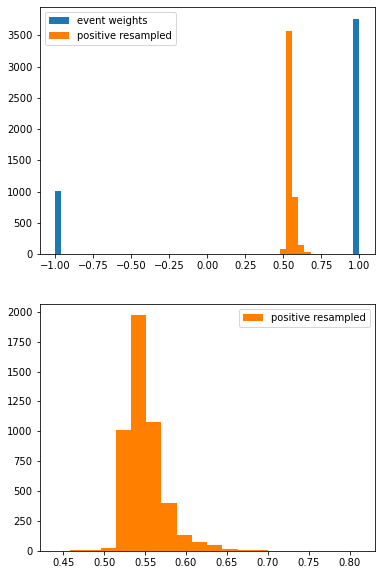

In [16]:
fig,ax = plt.subplots(2,1, figsize=(6,10))
plt.sca(ax[0])
plt.hist(targetweights, range=(-1, 1), bins=50, log=False, label='event weights')
plt.hist(yout[:,0], range=(-1, 1), color=(1.0, 0.5, 0.0), bins=50, label='positive resampled')
plt.legend()
plt.sca(ax[1])
plt.hist(yout[:,0], bins=20, color=(1.0, 0.5, 0.0), label='positive resampled')
plt.legend()
plt.show()

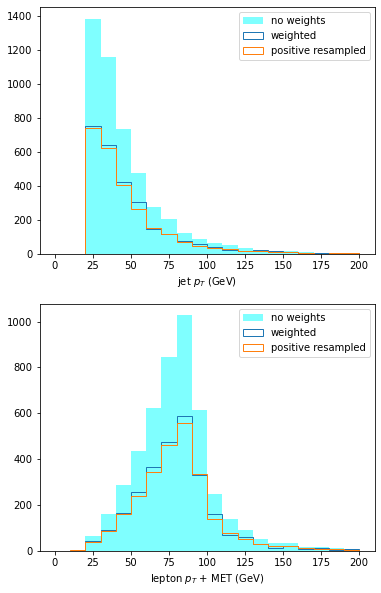

In [33]:
logy = False
normed = False
nbins = 20


fig,ax = plt.subplots(2,1, figsize=(6,10))
plt.sca(ax[0])
var = df['wjet.jetpt']
xrange = (0.0, 200.0)
plt.hist(var, range=xrange, bins=nbins, density=normed, log=logy, color=(0.0, 1.0, 1.0, 0.5), label='no weights')
ax[0].set_xlabel('jet $p_T$ (GeV)')
plt.hist(var, range=xrange, density=normed, weights=targetweights, histtype='step', bins=nbins, label='weighted')
plt.hist(var, range=xrange, density=normed, weights=yout, bins=nbins, histtype='step', label='positive resampled')
plt.legend()
plt.sca(ax[1])
var =  df['wjet.leppt'] + df['wjet.met']
xrange = (0.0, 200.0)
plt.hist(var, range=xrange, bins=nbins, density=normed, log=logy, color=(0.0, 1.0, 1.0, 0.5), label='no weights')
ax[1].set_xlabel('lepton $p_T$ + MET (GeV)')
plt.hist(var, range=xrange, density=normed, weights=targetweights, histtype='step', bins=nbins, label='weighted')
plt.hist(var, range=xrange, density=normed, weights=yout, bins=nbins, histtype='step', label='positive resampled')
plt.legend()
plt.show()

In [18]:
df['wjet.jeteta']-df['wjet.lepeta']

entry
0      -0.311358
1       2.264742
2       2.072861
3       1.965642
4       4.076337
          ...   
4759   -0.360979
4760    1.250065
4761   -3.790801
4762    1.820399
4763   -3.198500
Length: 4764, dtype: float32